In [1]:
# modelagem e dados
import torch
from torchvision import transforms, datasets
from torch import nn, optim
from torch.utils import data


# avaliação de modelos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# plotting e visualização
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# As imagens são carregadas internamente com uma biblioteca de processamento de
# imagens e precisam ser convertidas para um formato apropriado (ToTensor)
transform = transforms.ToTensor()

In [3]:
train_ds = datasets.MNIST(
    root = ".",
    train = True,
    download = True,
    transform = transform
)

# Criar um conjunto de validação a partir de um subconjunto aleatório
# com 15% dos dados de treino originais
length = len(train_ds)
len_val = int(0.15 * length)
len_train = length - len_val
train_ds, val_ds = data.random_split(train_ds, [len_train, len_val])

test_ds = datasets.MNIST(
    root = ".",
    train = False,
    download = True,
    transform = transform
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:01<00:00, 5804845.11it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 147305.38it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:50<00:00, 32637.47it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14531295.78it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [8]:
# valores iniciais para o tamanho dos batches
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_EVAL = 128

In [9]:
train_dl = data.DataLoader(
    train_ds, batch_size=BATCH_SIZE_TRAIN, shuffle=True,
    num_workers=2, pin_memory=True
)

val_dl = data.DataLoader(
    val_ds, batch_size=BATCH_SIZE_EVAL, shuffle=True,
    num_workers=2, pin_memory=True
)

test_dl = data.DataLoader(
    test_ds, batch_size=BATCH_SIZE_EVAL, shuffle=True,
    num_workers=2, pin_memory=True
)

In [10]:
instances, targets = next(iter(test_dl))
instances.shape, targets.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

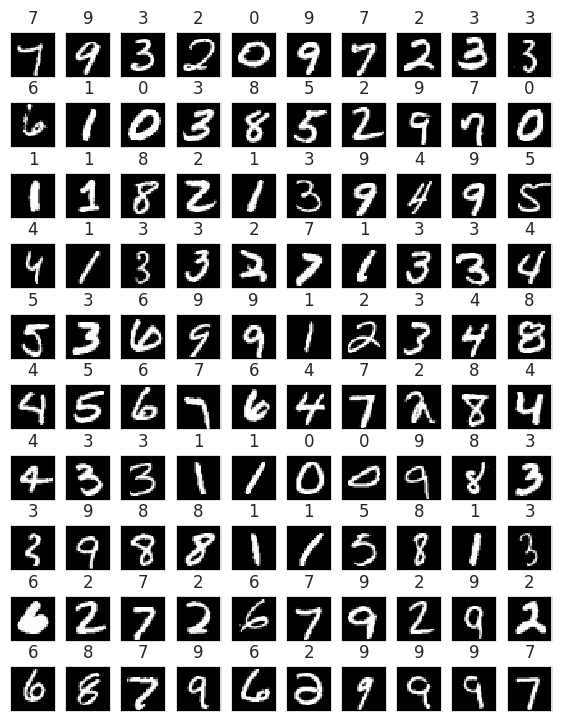

In [11]:
w = 10
fig, ax = plt.subplots(w, w, figsize=(7, 9))
for i in range(w):
  for j in range(w):
    ax[i][j].imshow(instances[i * w + j].permute(1, 2, 0), cmap="gray", interpolation="None")
    label = targets[i * w + j].item()
    ax[i][j].set_title(label)
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])

In [37]:
class MLP(nn.Module):
  def __init__(self, n_classes):
    super().__init__() # necessário sempre

    self.flatten = nn.Flatten()

    self.mlp = nn.Sequential(
        nn.Linear(784, 10),
        nn.Sigmoid(),
        nn.Linear(10, 10)
    )

  # Esse método é necessário. Executada o passo feed-forward da computação da
  # rede neural.
  def forward(self, x):
    x_flat = self.flatten(x)
    logits = self.mlp(x_flat)
    return logits

In [38]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [39]:
modelo = MLP(10).to(device)

In [40]:
summary(modelo, input_size=(1, 28, 28), batch_size=BATCH_SIZE_TRAIN, device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [64, 784]               0
            Linear-2                   [64, 10]           7,850
           Sigmoid-3                   [64, 10]               0
            Linear-4                   [64, 10]             110
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.40
Params size (MB): 0.03
Estimated Total Size (MB): 0.62
----------------------------------------------------------------


In [47]:
loss_fn = nn.CrossEntropyLoss()
LEARNING_RATE = 1.0
optimizer = optim.SGD(modelo.parameters(), lr=LEARNING_RATE)
EPOCHS = 30

In [42]:
class AverageMeter:
    """Computes and stores the average and current value"""
    # fonte: https://kaiyangzhou.github.io/deep-person-reid/_modules/torchreid/utils/avgmeter.html#AverageMeter
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [50]:
def train_step(model, train_dl, loss_fn, optimizer, device):
  # ativar modo de treino
  model.train()

  train_loss = AverageMeter()
  for train_instances, instance_labels in train_dl:
    # mover o lote e os rotulos para o mesmo dispositivo do modelo
    train_instances = train_instances.to(device)
    instance_labels = instance_labels.to(device)

    # fazer previsão com o modelo
    logits = model(train_instances)
    #print("Logits shape:", logits.shape)
    #print("Labels shape:", instance_labels.shape)


    # zerar os gradientes para evitar acumular
    optimizer.zero_grad()

    # calcular função de perda
    loss = loss_fn(logits, instance_labels)
    train_loss.update(loss.item(), len(train_instances))

    # retropropagar perda (backpropagation) para obter gradientes
    loss.backward()

    # aplicar a atualização dos parametros da rede baseado nos gradientes
    optimizer.step()
  return train_loss.avg

In [44]:
def validation_step(model, val_dl, loss_fn, device):
  # ativar modo de avaliação
  model.eval()

  val_loss = AverageMeter()
  # desativar computação de gradientes
  with torch.no_grad():
    for val_instances, instance_labels in val_dl:
      # mover o lote e os rotulos para o mesmo dispositivo do modelo
      val_instances = val_instances.to(device)
      instance_labels = instance_labels.to(device)

      # fazer previsão com o modelo
      logits = model(val_instances)

      # calcular função de perda
      loss = loss_fn(logits, instance_labels)
      val_loss.update(loss.item(), len(val_instances))
  return val_loss.avg

In [48]:
history = {
    "train_loss": [],
    "val_loss": []
}

In [51]:
for epoch in range(EPOCHS):
  train_loss = train_step(modelo, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(modelo, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Época [1/30]
-----------------------------------
Train loss: 0.348897
Valid. loss: 0.303567

Época [2/30]
-----------------------------------
Train loss: 0.29989
Valid. loss: 0.269864

Época [3/30]
-----------------------------------
Train loss: 0.281795
Valid. loss: 0.265193

Época [4/30]
-----------------------------------
Train loss: 0.270499
Valid. loss: 0.266342

Época [5/30]
-----------------------------------
Train loss: 0.259055
Valid. loss: 0.271205

Época [6/30]
-----------------------------------
Train loss: 0.252528
Valid. loss: 0.258514

Época [7/30]
-----------------------------------
Train loss: 0.245862
Valid. loss: 0.251848

Época [8/30]
-----------------------------------
Train loss: 0.240257
Valid. loss: 0.270482

Época [9/30]
-----------------------------------
Train loss: 0.236036
Valid. loss: 0.263031

Época [10/30]
-----------------------------------
Train loss: 0.232582
Valid. loss: 0.261009

Época [11/30]
-----------------------------------
Train loss: 0.228912

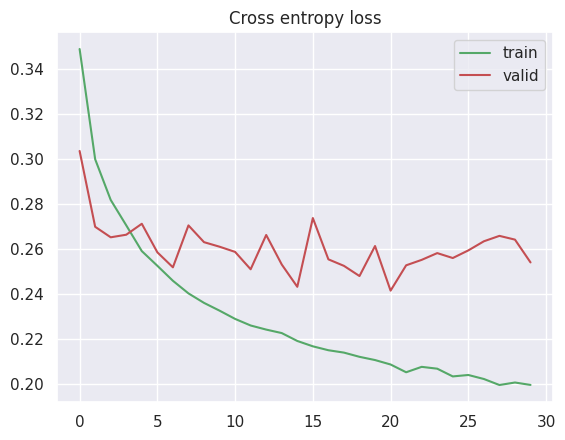

In [52]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

In [54]:
all_probs = []
all_preds = []
all_targets = []

total_corrects = 0
total_n = 0
modelo.eval()
for test_instances, instance_labels in test_dl:
    test_instances = test_instances.to(device)
    instance_labels = instance_labels.to(device)

    with torch.no_grad():
        logits = modelo(test_instances)
    probabilities = nn.functional.softmax(logits, 1)
    all_probs.append(probabilities.cpu())
    preds = torch.argmax(probabilities, 1)

    total_corrects += (preds == instance_labels).sum().item()
    total_n += len(test_instances)

    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(instance_labels.unsqueeze(-1))


preds = torch.cat(all_preds).squeeze(-1).cpu()
targets = torch.cat(all_targets).squeeze(-1).cpu()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


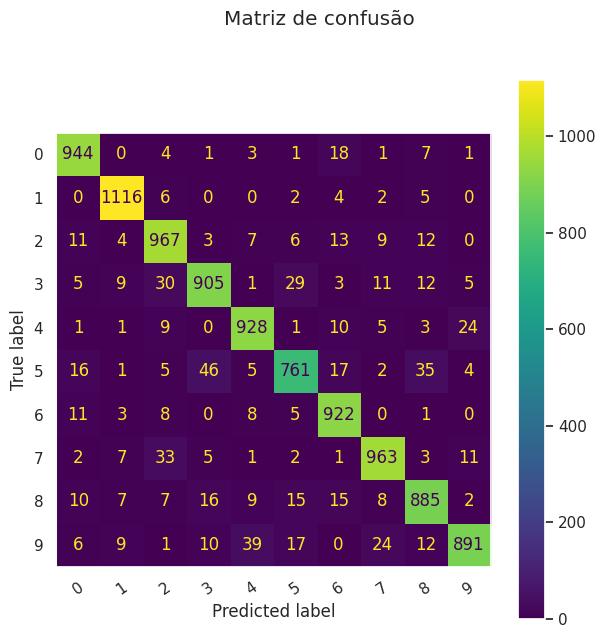

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
fig.suptitle("Matriz de confusão")
ax.grid(False)

labels = list(str(i) for i in range(10))

cm = confusion_matrix(targets, preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)
cm_display.plot(ax=ax, xticks_rotation=35.0)

In [57]:
print(classification_report(targets, preds, target_names=labels, zero_division=0))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.96      0.98      0.97      1135
           2       0.90      0.94      0.92      1032
           3       0.92      0.90      0.91      1010
           4       0.93      0.95      0.94       982
           5       0.91      0.85      0.88       892
           6       0.92      0.96      0.94       958
           7       0.94      0.94      0.94      1028
           8       0.91      0.91      0.91       974
           9       0.95      0.88      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

